Hay una formula a seguir a la hora de juntar jugadores para que formen una pareja de padel?

El objetivo del trabajo es evaluar si hay combinaciones entre jugadores de padel que tengan mas probabilidades de ganar un partido y tambien si hay combinaciones con pocas probabilidades de exito. Para esto analizaremos las estadisticas de juego de cada uno y las estadisticas de los partidos, diferenciando equipo que ganó el set y equipo que lo perdió

Un aspecto particular del padel es que se puede cambiar de pareja varias veces al año, si un jugador quiere cambiar de compañero, lo puede hacer sin restricciones. Esto es una herramienta muy utilizada por los jugadores para sobrellevar los malos resultados, con sus pros y contras


Aplicacion estrategica: es importante destacar, que a diferencia de otros deportes, el padel es un deporte en crecimiento y los premios monetarios que representan una real diferencia económica son para los primeros puestos del torneo, por lo que, encontrar una fórmula para maximizar las posibilidades de terminar entre los primeros, es decisivo para la carrera de un jugador de padel profesional y los entrenadores, que también van cambiando según cambian las parejas. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import statsmodels.api as sm
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
df_data = pd.read_excel("_ml_jug.xlsx")

Análisis del dataset

In [3]:
df_data.shape

(1128, 26)

In [4]:
df_data.columns

Index(['nombre', 'edad', 'alt', 'pos', 'torneo', 'set', 'saque', 'NF_total',
       'w_total', 'sm_total', 'nsmtotal', 'prec sm%', 'csm', 'fondo', 'm3',
       'm5', 'm7', 'pts_ganados', 'games_jug', 'circuito', 'fase', 'mano',
       'spcsm', 'bloc', 'partido', 'nfr'],
      dtype='object')

In [5]:
round(df_data.describe(),2)

,edad,alt,saque,NF_total,w_total,sm_total,nsmtotal,prec sm%,csm,fondo,m3,m5,m7,pts_ganados,games_jug,spcsm,bloc,nfr
count,1128.00,1128.00,1128.0,1128.00,1128.00,1128.00,1128.00,840.00,1128.00,1128.00,1128.00,1128.00,1128.00,1128.00,1128.00,424.00,424.00,80.00
mean,27.14,1.81,1.5,2.03,3.41,1.61,0.83,64.78,0.35,0.25,1.05,1.74,3.69,6.48,4.72,0.45,0.15,1.50
std,6.14,0.05,0.5,1.58,2.42,1.78,1.14,34.18,0.69,0.53,1.22,1.57,2.30,3.39,0.89,0.71,0.45,1.40
min,18.00,1.67,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00
25%,23.00,1.75,1.0,1.00,2.00,0.00,0.00,50.00,0.00,0.00,0.00,1.00,2.00,4.00,4.00,0.00,0.00,0.00
50%,26.00,1.80,1.5,2.00,3.00,1.00,0.00,67.00,0.00,0.00,1.00,1.00,3.00,6.00,5.00,0.00,0.00,1.00
75%,29.00,1.85,2.0,3.00,5.00,2.00,1.00,100.00,1.00,0.00,2.00,3.00,5.00,9.00,5.00,1.00,0.00,2.25
max,47.00,1.90,2.0,9.00,13.00,9.00,7.00,100.00,6.00,3.00,9.00,9.00,15.00,17.00,6.00,3.00,3.00,4.00


In [6]:
serie_nan =df_data.isna().sum()


l_na =  [col for col in serie_nan if col != 0]

serie_nan[serie_nan.isin(l_na)]




prec sm%     288
spcsm        704
bloc         704
partido      704
nfr         1048
dtype: int64

Hay valores NaN en prec sm% - esto seria la efectividad de los remates, pero como hay jugadores que no rematan en un set, para no computar un 0 en su promedio, se lo deja como Nan. Al hacer la media total de cada caracteristica, este valor va a dejar de ser Nan porque todos los jugadores remataron al menos una vez
Las ultimas 4 caracteristicas van a ser borradas del df ya que no hay de todos los jugadores, y no son importantes

## Creacion de nuevo dataframe (df)
Se va a crear un df dividiendo las caracteristicas por la cantidad de games jugados.
Se eligieron las 3 columnas mas relevantes al analizar partidos, como son los puntos por game (pxg), errores no forzados por game (nfxg) y remates por game (rem). Ademas, se creó una variable sintetica, que es el resultado de restarle a los puntos que hace por game el jugador sus errores no forzados, se llamará pts_netos

In [7]:
df_clean = pd.DataFrame()
df_clean = df_clean.assign(name = df_data["nombre"])
df_clean = df_clean.assign(pxg = df_data["pts_ganados"]/df_data['games_jug'])
df_clean= df_clean.assign(nfxg = df_data["NF_total"]/df_data['games_jug'])
df_clean = df_clean.assign(rem = (df_data["sm_total"] + df_data["nsmtotal"])/df_data['games_jug'])

#creacion de columna puntos netos
df_clean["pts_netos"] = df_clean["pxg"] - df_clean["nfxg"]

df_clean = df_clean.groupby("name")[["pxg","nfxg","pts_netos","rem"]].mean().sort_values(by="pxg", ascending=False)

df_clean1 = df_clean.reset_index(drop=True)







## Outliers


<AxesSubplot:>

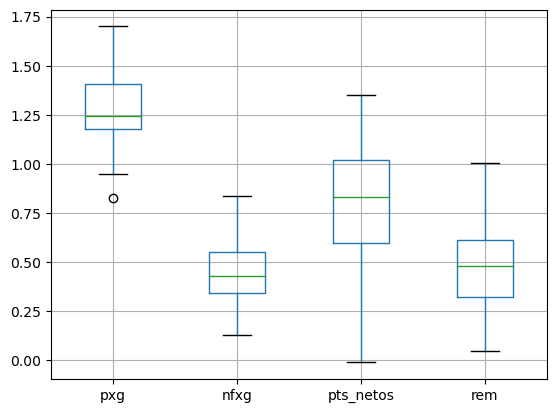

In [8]:
df_clean1.boxplot()


In [9]:
#identificar el outlier
print(df_clean1[df_clean1["pxg"] ==df_clean1["pxg"].min()])
print(df_clean[df_clean["pxg"] ==df_clean["pxg"].min()])

      pxg    nfxg  pts_netos    rem
49  0.825  0.8375    -0.0125  0.425
           pxg    nfxg  pts_netos    rem
name                                    
Alfonso  0.825  0.8375    -0.0125  0.425


In [10]:
#negativos
neg= df_clean["pts_netos"] < 0
neg1 =df_clean1["pts_netos"] < 0


#eliminamos al outlier ya que es el unico jugador que tiene negativo en puntos_netos, lo cual depende de la cantidad de partidos
df_clean.drop("Alfonso",inplace =True)
df_clean1.drop(49, inplace =True)

df_clean_val = df_clean.values

#nombre de los jugadores 
df_clean_index = df_clean.index



### 

C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a m

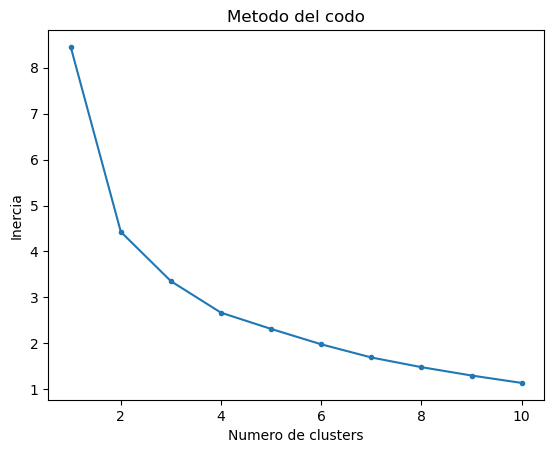

In [11]:
wcss = []
for i in range(1, 11):
    codo = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    codo.fit(df_clean_val)
    wcss.append(codo.inertia_)
plt.plot(range(1, 11), wcss, marker="o", ms=3)

plt.title('Metodo del codo')
plt.xlabel('Numero de clusters')
plt.ylabel('Inercia')
plt.show()

Si bien las posibilidades para agrupar podrian ser desde 2 cluster hasta 4, el análisis previo del deporte divide a los jugadores en 3 grupos: Los que se destacan por la cantidad de puntos que hacen(ofensivos), los que se destacan defensivamente (defensivos), y en el medio jugadores hibridos, asi que elegimos separar a los jugadores en 3 clusters

Instanciar modelo 

In [12]:
model = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=5)
pred_y = model.fit_predict(df_clean)




C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


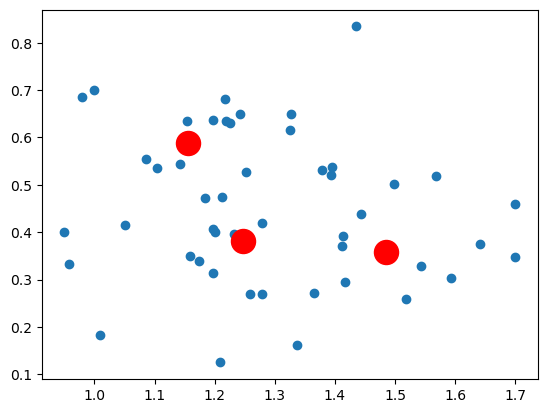

In [13]:
plt.scatter(df_clean_val[:,0], df_clean_val[:,1])
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=300, c='red')
plt.show()

# rescribir

## Preprocesado y modelado

Porcentaje de varianza explicada por cada componente
[6.23934727e-01 2.65912252e-01 1.10153021e-01 2.27943424e-32]


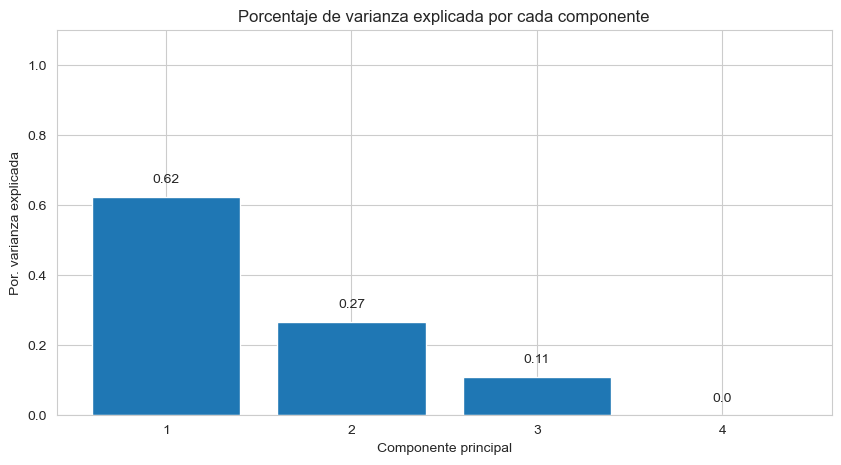

In [14]:
df_cluster =df_clean1
# Entrenamiento modelo PCA con escalado de los datos
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(df_cluster)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

# Porcentaje de varianza explicada por cada componente
print('Porcentaje de varianza explicada por cada componente')
print(modelo_pca.explained_variance_ratio_)

import seaborn as sns;sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.bar(x= np.arange(modelo_pca.n_components_) + 1,height = modelo_pca.explained_variance_ratio_)
for x, y in zip(np.arange(len(df_cluster.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha='center')
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1);ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada')
plt.show()



Se utilizarán los 2 primeros componentes, que explican un 88% de la variacion del dataframe

In [15]:
#Utilizar los 2 primeros componentes del PCA
df_pca = pd.DataFrame(data = modelo_pca.components_, columns=df_cluster.columns, 
             index = ["PC1","PC2","PC3","PC4"])

proyecciones = pca_pipe.transform(X=df_cluster)

proyecciones = pd.DataFrame(data = proyecciones,columns =  ["PC1","PC2","PC3","PC4"],
                           index = df_cluster.index)

proyecciones = proyecciones[["PC1", "PC2"]]

proyecciones.head(2)

,PC1,PC2
0,-3.172079,0.394035
1,-2.546195,0.936311


In [16]:
#Graficar clusters

#model con cluster
modelcc = model.fit(proyecciones)

#obtener labels del modelo fitteado
labels = modelcc.labels_

#agregar los labels al df
df_clean1['cluster_label'] = labels

#representamos puntos y centroides
# Obtener los Centroides
centroids = modelcc.cluster_centers_

centroids_x = centroids[:,0]
centroids_y = centroids[:,1]


#cambiar el index por nombres de los jugadores
df_clean1.set_index(df_clean_index, inplace=True)
#print(cc1.sort_values("cluster_label"))
maskcc0 = (df_clean1['cluster_label'] == 0)
maskcc1 = (df_clean1['cluster_label'] == 1)
maskcc2 = (df_clean1['cluster_label'] == 2)


#colores
fondo = "#313332"
verde_lindo = "#46f892"
verde_claro = "#b5fdcd"
scattermedia ="#42424d" #alpha=0.9
text_color = "w"
color_set1 = '#3ff294' # gran verde
color_set2 = '#f4aa51' # amarillo arena naranja
celeste = "#31acce" 
celeste_claro = "#c1e6f0"


# Obtén las coordenadas de los puntos
x = df_clean1['pxg']
y = df_clean1['rem']
names = df_clean_index  # Nombres de los puntos

C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Los datos de cada jugador en particular por game

In [17]:
df_clean1.head()

,pxg,nfxg,pts_netos,rem,cluster_label
name,,,,,
Dalbianco,1.700000,0.346970,1.353030,0.709848,2
Paquito,1.699123,0.458772,1.240351,0.664912,2
Tolito,1.641667,0.375000,1.266667,0.486667,2
Coello,1.593269,0.302564,1.290705,0.759295,2
Stupa,1.567568,0.518919,1.048649,0.666892,2


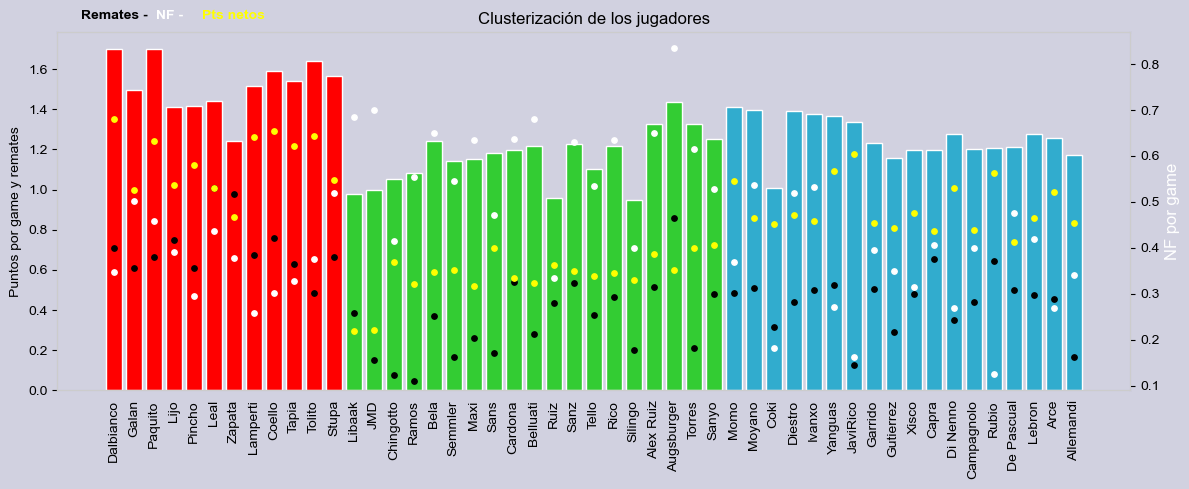

In [18]:
def g_bar(df):
    # Crea el gráfico scatter con nombres
    df= df.sort_values("cluster_label", ascending=False)
    
    fig, ax = plt.subplots(figsize=(12,5))
    fig.set_facecolor("#d1d1e0")
    name1 = "pts x game"
    name2 = "NF"
    name3 = "Rem"
    
    width = 0.2
    index = np.arange(3)
    
    

    verde_lindo= "#33cc33"
    ax.patch.set_facecolor("#d1d1e0")
    #sns.barplot(x= df.index, y=df["rem"], hue=df["cluster_label"])
    # Define una paleta de colores personalizada
    colores = [celeste, verde_lindo, "red"]

    # Asigna colores a las barras en función de los valores de "cluster_label"
    colores_barras = [colores[label] for label in df["cluster_label"]]
    ax.bar(df.index, df["pxg"], color=colores_barras)
    ax.scatter(df.index, df["rem"], color ="black", s=15)
    ax.scatter(df.index, df["pts_netos"], color ="yellow",s=15)
    plt.xticks(rotation=90)
    ax.set_ylabel("Puntos por game y remates", color = "black")
    
    #compartir eje x 
    ax2 = ax.twinx()
    ax2.scatter(df.index, df["nfxg"], color ="white",s=15) 
   
    ax2.set_ylabel("NF por game", color = "white", fontsize=12)

    #cambiar colores
    ax.tick_params(axis="y", colors="black")
    ax2.tick_params(axis="y", colors="black")
    ax.tick_params(axis="x", colors="black")
   
    
    plt.title("Clusterización de los jugadores", color="black")
    ax.xaxis.grid(False)  # Desactivar las líneas de la cuadrícula en el eje x
    ax.yaxis.grid(False)
    #ax.grid(False)
    ax2.grid(False)
    ax.text(0.1, 1.85, "Remates - ", color="black", weight='bold', ha='center')
    ax.text(2.8, 1.85, "NF -", color="white", weight='bold', ha='center')
    ax.text(6, 1.85, "Pts netos", color="yellow", weight='bold', ha='center')
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()
g_bar(df_clean1)

Evaluacion de silhouette

In [19]:
df_clean1.head(2)

,pxg,nfxg,pts_netos,rem,cluster_label
name,,,,,
Dalbianco,1.700000,0.346970,1.353030,0.709848,2
Paquito,1.699123,0.458772,1.240351,0.664912,2


In [20]:
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler

valor_x = df_clean1.drop("cluster_label", axis=1).values

valor_y = df_clean1.cluster_label.values

sc = StandardScaler()
valor_x_norm =sc.fit_transform(valor_x)
slc = {}

for k in range(2,6):
    kmeans = KMeans(n_clusters=k, max_iter=100, random_state=10).fit(valor_x_norm)
    clusters =kmeans.labels_
    slc[k] = silhouette_score(valor_x_norm, clusters)
    
slc


C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with

{2: 0.3686168785704656,
 3: 0.3017875054212996,
 4: 0.2945273600069231,
 5: 0.2821558728795745}

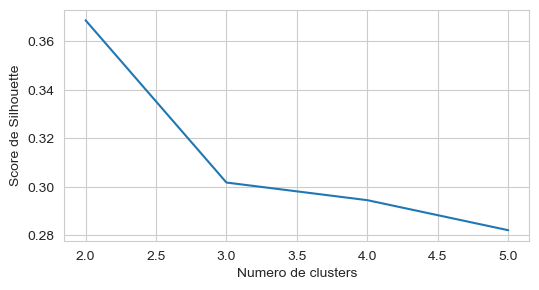

In [21]:
plt.figure(figsize=(6,3))
plt.plot(list(slc.keys()), list(slc.values()))
plt.xlabel("Numero de clusters")
plt.ylabel("Score de Silhouette")
plt.show()

# Análisis del ranking según clusters

### Cluster 1: 
Jugadores que realizan menos remates que la media es el rasgo principal. Tambien, suelen cometer mas errores no forzados que la media, y la cantidad de puntos es variada, pero suelen hacer entre la media y menos.

### Cluster 2: 
Son jugadores hibridos, presentan valores intermedios entre el cluster 1 y 3.

### Cluster 3: 
Son jugadores que realizan mas puntos que la media y mas remates. Errores no forzados es variado.

### Parejas segun ranking:

#### Numero 1: 
Son 2 jugadores del cluster 3.Ambos estan por encima del percentilo 85 en puntos por game, única pareja que tiene a 2 jugadores con tantos puntos, y ademas son la pareja que menos errores no forzados comete. Hacen muchos puntos y otorgan pocos al rival. Como detalle no menor, tambien son los que mas rematan, teniendo una de las efectividades mas altas además. Se encuentran invictos.

#### Numero 2: 
Tiene un jugador del cluster 3 y el otro es un hibrido, cluster 2, que tiene partidos en los cuales se vuelve mas ofensivo y tiene menos errores no forzados que su compañero

#### Numero 3: 
Tiene un jugador del cluster 3 y el otro es un hibrido, cluster 2, que tiene partidos en los cuales se vuelve mas defensivo y es de los que menos errores no forzados tiene en el torneo

#### Numero 4: 
Tiene 2 jugadores hibridos, cluster 2. Uno de ellos el que mas puntos hace por game en el cluster 2 y con pocos errores no forzados. En cambio, su pareja, tiene rendimientos mas variado, sobretodo en lo que respecta a errores no forzados.

#### Numero 5: 
Tiene un jugador del cluster 3, siendo el que mas puntos hace en el torneo, y a un jugador del cluster 1, quien hace pocos puntos (los termina haciendo su compañero) y comete muy pocos errores no forzados

##### Esto denota que no hay una formula única en el armado de parejas con respecto a los roles de cada jugador

## En cuanto a las combinaciones con pocas probabilidades de exito:
Es una tentación juntar 2 jugadores que hagan muchos puntos por game, sin embargo, estos jugadores suelen estar por encima del percentilo 50 en errores no forzados, y juntar a jugadores que "compitan" por hacer puntos y se "hundan" por los errores no forzados no ha tenido buenos resultados; excepto los actuales numero 1, pero ellos comenten muy pocos errores no forzados, ambos

Numero 1: son 2 jugadores del cluster 3.Ambos estan por encima del percentilo 85 en puntos por game, única pareja que tiene a 2 jugadores con tantos puntos, y ademas son la pareja que menos errores no forzados comete. Hacen muchos puntos y otorgan pocos al rival. Como detalle no menor, tambien son los que mas rematan, teniendo una de las efectividades mas altas además. Se encuentran invictos.

In [22]:
def jug_valor(df,name,name2, name3,r):
    
    #jug1
    pxg= round(df.loc[name, "pxg"],2)
    nfxg= round(df.loc[name, "nfxg"],2)
    rem= round(df.loc[name, "rem"],2)
    rank = r
    
    #jug2
    pxg2= round(df.loc[name2, "pxg"],2)
    nfxg2= round(df.loc[name2, "nfxg"],2)
    rem2= round(df.loc[name2, "rem"],2)
        
    #equipo
    pxg3 = pxg + pxg2
    nfxg3 =nfxg + nfxg2
    rem3 = rem + rem2
    
    #crear df
    df_jug = pd.DataFrame({"Puntos por game":[pxg, pxg2],
                           "No forzados":[nfxg, nfxg2],
                           "Puntos netos": [pxg - nfxg, pxg2 -nfxg2],
                           "Remates": [rem,rem2],
                     "Ranking": [r,r]},
                          index= [name, name2])
    
    df_eq =pd.DataFrame({"Puntos por game":[pxg3],
                           "No forzados":[nfxg3],
                         "Puntos netos": [pxg3 - nfxg3],
                           "Remates": [rem3],
                     "Ranking": [r]},
                          index= [name3])
            
    
    return df_jug, df_eq
medias_desc = df_clean1.describe().T

m_pxg = medias_desc.loc["pxg", "mean"]/ df_clean1["pxg"].sum()
m_nfxg = medias_desc.loc["nfxg", "mean"]/df_clean1["nfxg"].sum()
m_pts_netos = medias_desc.loc["pts_netos", "mean"]/df_clean1["pts_netos"].sum()
m_rem = medias_desc.loc["rem", "mean"]/df_clean1["rem"].sum()

df_clean1.describe().T


,count,mean,std,min,25%,50%,75%,max
pxg,49.0,1.285968,0.187704,0.950000,1.183333,1.241667,1.412179,1.700000
nfxg,49.0,0.450325,0.156456,0.125000,0.340000,0.418750,0.544444,0.834375
pts_netos,49.0,0.835643,0.260696,0.294444,0.600000,0.834167,1.022222,1.353030
rem,49.0,0.468332,0.220109,0.045000,0.314583,0.481090,0.611806,1.006250
cluster_label,49.0,0.877551,0.780829,0.000000,0.000000,1.000000,1.000000,2.000000


In [23]:
df_n1,df_eq1 = jug_valor(df_clean1,"Tapia","Coello", "Tapia-Coello","1")
df_n2,df_eq2 = jug_valor(df_clean1,"Galan","Lebron", "Galan-Lebron","2")
df_n3,df_eq3 = jug_valor(df_clean1,"Stupa","Di Nenno", "Stupa-Di Nenno","3")
df_n4, df_eq4 = jug_valor(df_clean1,"Momo","Sanyo", "Momo-Sanyo","4")
df_n5,df_eq5 = jug_valor(df_clean1,"Paquito","Chingotto", "Paquito-Chingotto","5")

#df_n1["Ranking"] 
#df_n1 =df_n1.T
df_rank = pd.concat([df_n1,df_n2,df_n3,df_n4,df_n5])
df_eq_rank = pd.concat([df_eq1,df_eq2,df_eq3,df_eq4,df_eq5])

print(df_eq_rank)
df_rank
                          

                           

                   Puntos por game  No forzados  Puntos netos  Remates Ranking
Tapia-Coello                  3.13         0.63          2.50     1.39       1
Galan-Lebron                  2.78         0.92          1.86     1.09       2
Stupa-Di Nenno                2.85         0.79          2.06     1.02       3
Momo-Sanyo                    2.66         0.90          1.76     0.96       4
Paquito-Chingotto             2.75         0.87          1.88     0.74       5


,Puntos por game,No forzados,Puntos netos,Remates,Ranking
Tapia,1.54,0.33,1.21,0.63,1
Coello,1.59,0.30,1.29,0.76,1
Galan,1.50,0.50,1.00,0.61,2
Lebron,1.28,0.42,0.86,0.48,2
Stupa,1.57,0.52,1.05,0.67,3
Di Nenno,1.28,0.27,1.01,0.35,3
Momo,1.41,0.37,1.04,0.48,4
Sanyo,1.25,0.53,0.72,0.48,4
Paquito,1.70,0.46,1.24,0.66,5
Chingotto,1.05,0.41,0.64,0.08,5


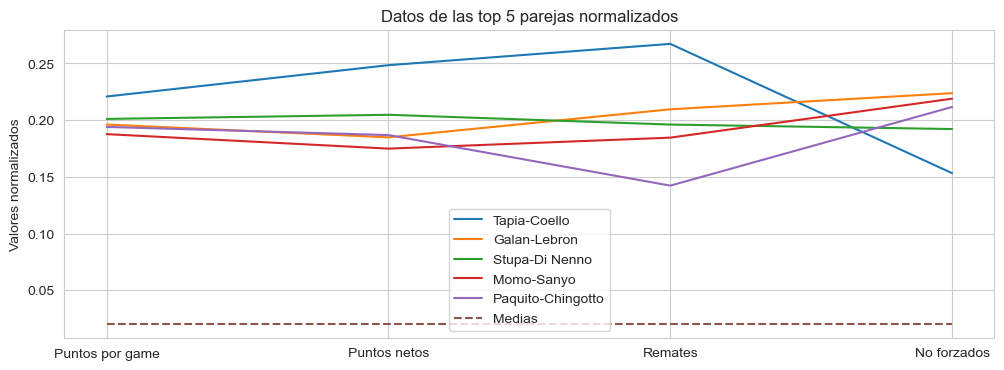

In [24]:
df_plot = df_eq_rank.drop("Ranking", axis=1).reset_index()


#plt.plot(df_eq_rank[:4],df_eq_rank.values[:4)
tap_coe = df_plot[df_plot["index"] == "Tapia-Coello"]


l_name = df_plot["index"].to_list()

#xx = df_plot["Puntos por game", "No forzados", "Puntos netos", "Remates"]

l_cols =["Puntos por game", "Puntos netos", "Remates", "No forzados"]

#normalizar columnas
for i in l_cols:
    df_plot[i] = df_plot[i].apply(lambda x: x/df_plot[i].sum())

    
#medias de todos los jugadores nornalizadas
medias_desc = df_clean1.describe().T

m_pxg = medias_desc.loc["pxg", "mean"]/ df_clean1["pxg"].sum()
m_nfxg = medias_desc.loc["nfxg", "mean"]/df_clean1["nfxg"].sum()
m_pts_netos = medias_desc.loc["pts_netos", "mean"]/df_clean1["pts_netos"].sum()
m_rem = medias_desc.loc["rem", "mean"]/df_clean1["rem"].sum()
m_pxg, m_nfxg, m_pts_netos, m_rem    
    
    
# Graficar
fig, ax = plt.subplots(figsize=(12,4))

for i,name in enumerate(l_name):
    yy = df_plot[df_plot["index"]== name]
    yyy = yy[l_cols].values[0]
    ax.plot(l_cols, yyy, label = name)

l_medias =[m_pxg, m_nfxg, m_pts_netos, m_rem]

ax.plot(l_cols, l_medias, label="Medias", linestyle="--")
#yy = tap_coe[l_cols].values[0] #yy = tap_coe[l_cols].iloc[0]

ax.set_title("Datos de las top 5 parejas normalizados")
ax.set_ylabel("Valores normalizados")
plt.legend()  
plt.show()

Análisis teniendo en cuenta quién gana o pierde o empata (tiebreak) el set

In [25]:
#dataset con los datos por equipo con resultado - df_gop (gano o perdio)
df_gop = pd.read_excel("_ml1_eqxset.xlsx")

In [26]:
#quitar outlier de sd en bruselas 3er set
df_gop.drop(49, axis=0, inplace=True)
df_gop

,nombre,nf,w,sm,ns,prec,csm,fondo,m3,m5,...,sk_prim,games jug,sk_oro,resto_oro,op quiebre,circuito,torneo,fase,gano_set,nfr
0,Tap-Coe,2,11,3,4,43,1,4,9,11,...,s,10,100.0,NaN,100.0,WPT,Vigo,Final,g,NaN
1,Gal-Leb,10,16,6,1,86,3,0,4,1,...,n,10,NaN,0.0,0.0,WPT,Vigo,Final,p,NaN
2,Tap-Coe,9,22,12,5,71,2,1,2,11,...,n,12,100.0,33.0,25.0,WPT,Vigo,Final,tb,NaN
3,Gal-Leb,10,21,9,4,69,2,2,8,9,...,s,12,67.0,0.0,50.0,WPT,Vigo,Final,tb,NaN
4,Tap-Coe,4,25,10,10,50,4,1,2,10,...,s,12,67.0,0.0,38.0,WPT,Vigo,Final,tb,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,Paquito-Chingotto,9,15,3,3,50,3,0,5,7,...,n,10,33.0,0.0,33.0,WPT,Vigo,Cuartos,g,NaN
172,Momo-Sanyo,7,9,4,4,50,0,1,2,1,...,s,6,67.0,0.0,0.0,WPT,Vigo,Cuartos,tb,NaN
173,Paquito-Chingotto,4,12,4,2,67,2,1,4,3,...,n,6,0.0,33.0,17.0,WPT,Vigo,Cuartos,tb,NaN
174,Momo-Sanyo,7,10,7,3,70,0,0,5,3,...,n,8,0.0,100.0,75.0,WPT,Vigo,Cuartos,tb,NaN


In [27]:
#cambiar index 
df_gop.set_index('nombre',inplace=True)

#df con games ganados
df_gano = df_gop[df_gop["gano_set"]=="g"]
all_cols = ['nf', 'w', 'sm', 'ns', 'csm', 'fondo', 'm3', 'm5',
       'm7', 'pto_tot', 'tot_snf', 'ed','games jug', "set"]

#res_col = ["nf", "pto_tot", "tot_snf","sm","ns", "games jug"]
res_col = ["nf", "pto_tot", "tot_snf", "games jug"]


df_gano = df_gano[res_col]

df_ganoxgame = round(df_gano.div(df_gano["games jug"], axis=0),3)
df_ganoxgame["result"] ="g"


#df con games perdidos
df_perdio = df_gop[df_gop["gano_set"]=="p"]
df_perdio = df_perdio[res_col]

df_perdioxgame = round(df_perdio.div(df_perdio["games jug"], axis=0),3)
df_perdioxgame["result"] ="p"

#concatenar los df gano y perdio 

all = pd.concat([df_ganoxgame, df_perdioxgame])
all.drop("games jug", axis=1, inplace=True)
all["result"] = np.where(all["result"] == "g",1,0)
all

,nf,pto_tot,tot_snf,result
nombre,,,,
Tap-Coe,0.200,2.900,1.900,1
Tap-Coe,0.556,3.444,2.222,1
Tap-Coe,0.600,3.200,1.800,1
Momo-Sanyo,0.900,2.800,1.900,1
Tap-Coe,0.900,2.800,1.900,1
...,...,...,...,...
Leal-Bel,0.900,2.700,1.900,0
Leal-Bel,1.083,2.833,1.917,0
Galan-Sanz,1.500,1.625,0.875,0


In [28]:
#analisis univariado
univ = all.describe().T.drop(["result"])
univ

,count,mean,std,min,25%,50%,75%,max
nf,145.0,0.860890,0.336006,0.167,0.625,0.875,1.000,2.167
pto_tot,145.0,2.762083,0.649431,1.143,2.250,2.833,3.222,4.000
tot_snf,145.0,1.898966,0.490045,0.571,1.556,1.900,2.286,3.000


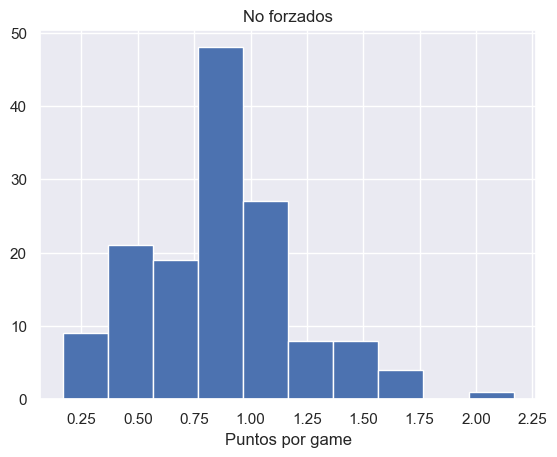

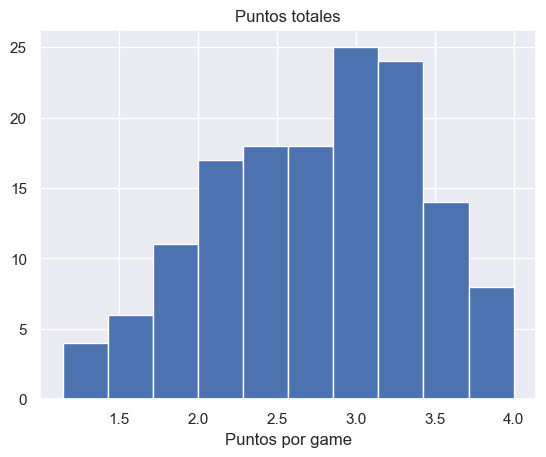

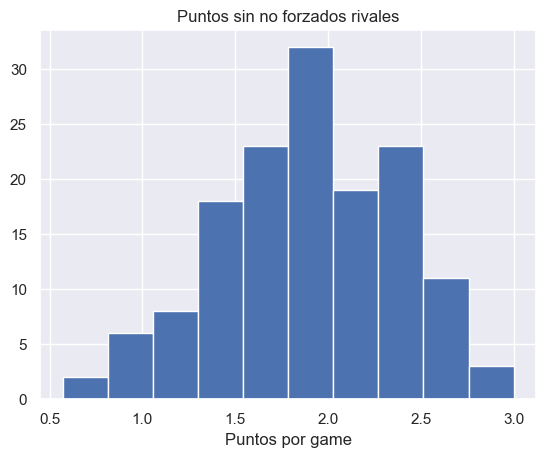

In [29]:
all_hist = all.drop("result", axis=1)
l_title = ["No forzados", "Puntos totales", "Puntos sin no forzados rivales"]
for i,g in enumerate(all_hist.columns):
    sns.set()
    plt.hist(all_hist[g])
    plt.xlabel("Puntos por game")
    plt.title(l_title[i])
    plt.show()

In [30]:
df_corr = all.corr()
df_corr.drop(["nf","pto_tot","tot_snf"], axis=1)

,result
nf,-0.522001
pto_tot,0.789150
tot_snf,0.694979
result,1.000000


nf: errores no forzados, pto_tot: puntos totales, tot_snf: puntos totales sin contar errores no forzados del rival, result: resultado, 1 es gana, 0 perder,

Hay una fuerte correlacion con result,(ganar) y los puntos que hace una pareja y los puntos totales con los puntos sin no forzados porque uno contiene al otro. Si bien se podría eliminar una de las columnas de los puntos, sirve tener las 2 columnas para diferenciar a los jugadores que hacen muchos puntos y tambien muchos errores no forzados de los que hacen muchos puntos y pocos errores no forzados, que son el ideal del padel y que mas sets ganan

Mientras que los errores no forzados muestran correlacion inversa con ganar, pero no tan fuerte como la cantidad de puntos hechos, ya que los puntos pueden superar a los errores no forzados y ganar el partido, a pesar de tener ambos valores altos

In [31]:
#errores no forzados 
plt.figure(figsize=(6, 2))
plt.scatter(all["nf"], all["result"], color="black")
plt.title("No forzados")
plt.yticks([0,1],["Perdedor","Ganador"])
plt.xlabel("Cantidad por game")
plt.margins(y=0.2)  # Ajusta el margen vertical

Se observa que hacer muy pocos errores no forzados (lo cual no es nada sencillo y suele ocurrrir cuando hay mucha diferencia en el ranking o una pareja en particular que son los numero 1 del ranking) es un buen predictor del triunfo del set.

Los errores no forzados tienen una correlacion con el resultado de: -0.522001, siendo que quien haga mas de 
estos tiene mas probabilidades de perder. Como se aprecia en el grafico, hay un rango de 0.47 a 1.35 puntos 
en los cuales se puede ganar o perder el set

In [32]:
#Puntos totales 
plt.figure(figsize=(6, 2))
plt.scatter(all["pto_tot"], all["result"], color="black")
plt.title("Puntos totales")
plt.yticks([0,1],["Perdedor","Ganador"])
plt.xlabel("Cantidad por game")
plt.margins(y=0.2)  # Ajusta el margen vertical

En el grafico se puede apreciar a simple vista que los ganadores del set suelen hacer mas puntos por set
de promedio. Hay partidos muy parejos en los cuales los perdedores han hecho mas de 2.6 puntos por set. Se puede intuir que para ganar hay que promediar mas de 2.6 puntos por game

In [33]:
#Puntos totales sin errores no forzados del rival 
plt.figure(figsize=(6, 2))
plt.scatter(all["tot_snf"], all["result"], color="black")
plt.title("Puntos totales sin errores no forzados del rival")
plt.yticks([0,1],["Perdedor","Ganador"])
plt.xlabel("Cantidad por game")
plt.margins(y=0.2)  # Ajusta el margen vertical

Teniendo en cuenta que para ganar el set, hay que promediar 2.6 puntos por game como minimo, equipos
que promedien mas de 2.4 puntos sin errores no forzados, ganan el partido el 100% de las veces, ya que
a los puntos que hacen hay que sumarle los puntos de los errores no forzados del rival